In [63]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.stats import norm
import seaborn as sns
import math

In [96]:
g = nx.DiGraph()

In [97]:
nodes = pd.read_csv("../data/nodes.csv")
nodes.drop(nodes.columns[[0, 5]], axis=1, inplace=True)
nodes.columns = nodes.columns.str.lstrip()
rows_as_dicts = nodes.to_dict('index')
nodes


,name,code,region,sub_region
0,Afghanistan,4,Asia,Southern Asia
1,Albania,8,Europe,Southern Europe
2,Algeria,12,Africa,Northern Africa
3,American Samoa,16,Oceania,Polynesia
4,Andorra,20,Europe,Southern Europe
...,...,...,...,...
227,Wallis and Futuna Islands,876,Oceania,Polynesia
228,Western Sahara,732,Africa,Northern Africa
229,Yemen,887,Asia,Western Asia
230,Zambia,894,Africa,Eastern Africa


In [98]:
for i, attrs in rows_as_dicts.items():
    g.add_node(i, **attrs)

In [99]:
edges = pd.read_csv("../data/edges.csv")
edges.rename(columns={edges.columns[0]: 'source'}, inplace=True)
edges.columns = edges.columns.str.lstrip()
edges = edges.set_index(['source', 'target'])

In [100]:
for i, attrs in edges.to_dict('index').items():
    g.add_edge(*i, **attrs)

In [15]:
unique_regions = set(nx.get_node_attributes(g, 'region').values())
color_map = {region: plt.cm.tab20(i) for i, region in enumerate(unique_regions)}
node_colors = [color_map[g.nodes[node]['region']] for node in g.nodes()]

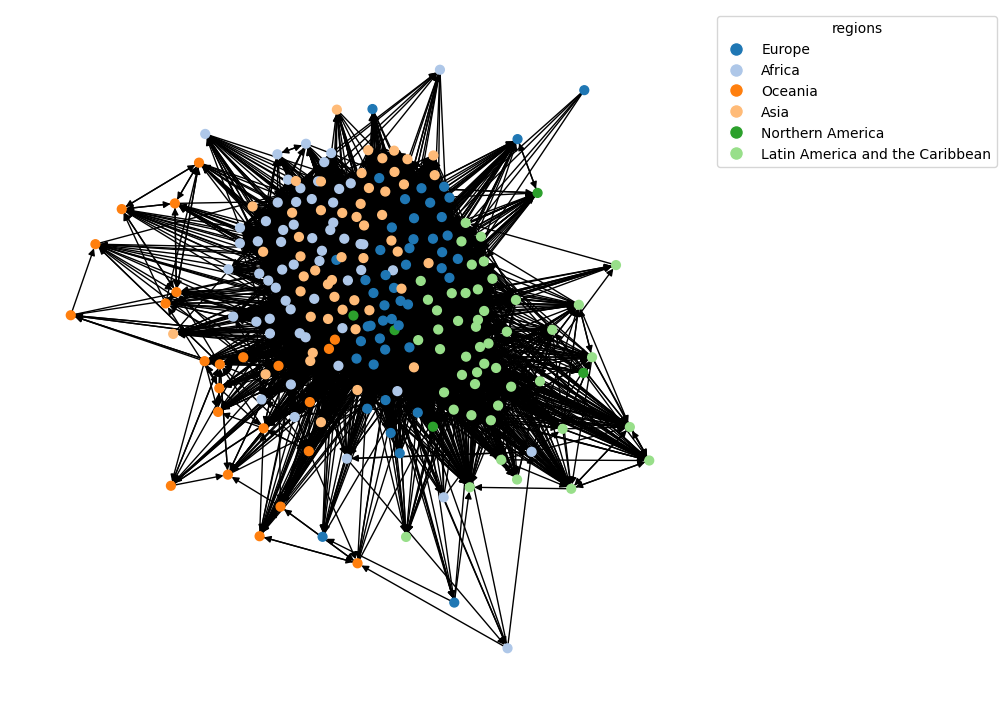

In [80]:
plt.figure(figsize=(7, 7))
nx.draw(g, node_color=node_colors, with_labels=False, node_size = 40)
region_patches = [plt.Line2D([0], [0], marker='o', color='w', label=region,
                          markerfacecolor=color, markersize=10)
                     for region, color in color_map.items()]
plt.legend(handles=region_patches, title="regions", loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [19]:
nn = nx.number_of_nodes(g)
ne = nx.number_of_edges(g)
print("Number of nodes: ", nn)
print("Number of edges: ",  ne)

Number of nodes:  232
Number of edges:  11228


In [31]:
density = nx.density(g)
weakly_connected = nx.is_weakly_connected(g)
strongly_connected = nx.is_strongly_connected(g)

print("Density:", density)
print("The graph", "is" if weakly_connected else "isn't" , "weakly connected")
print("The graph", "is" if strongly_connected else "isn't" , "strongly connected")

Density: 0.20950888192267503
The graph is weakly connected
The graph isn't strongly connected


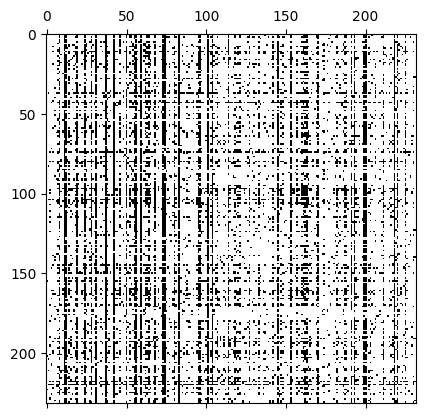

In [22]:
adj_matrix = nx.adjacency_matrix(g)
plt.spy(adj_matrix.todense())
plt.show()

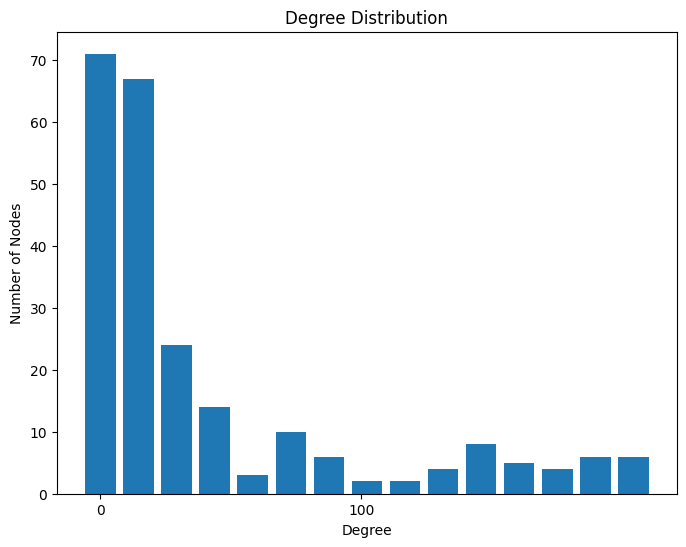

In [15]:
out_degrees = [degree for node, degree in g.out_degree]
in_degrees = [degree for node, degree in g.in_degree]

plt.figure(figsize=(8, 6))
plt.hist(in_degrees, align='left', rwidth=0.8, bins = "auto")
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.xticks(range(0, max(out_degrees) + 1, 100))
plt.show()

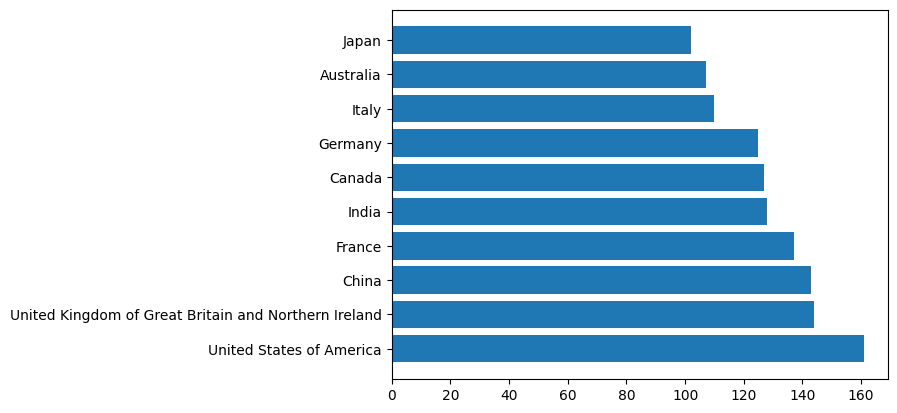

In [24]:
sorted_outd = sorted(g.out_degree(), key=lambda x:x[1], reverse = True)
plt.barh([g.nodes[id].get("name") for id, _ in sorted_outd[:10]], [value for _, value in sorted_outd[:10]])
plt.show()

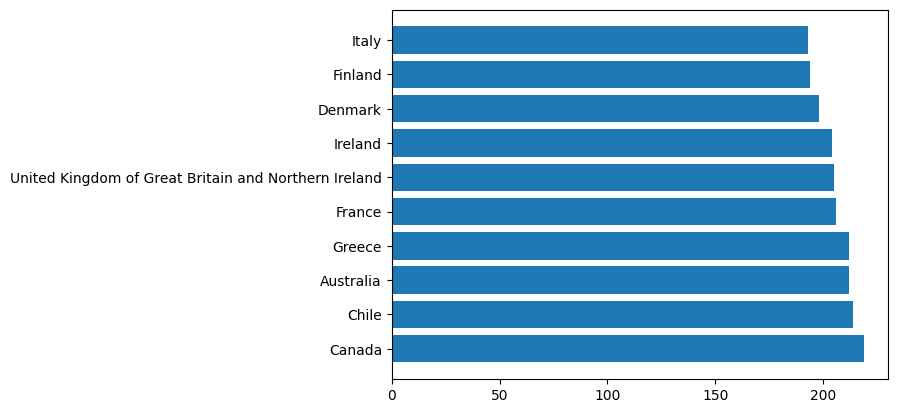

In [25]:
sorted_ind = sorted(g.in_degree(), key=lambda x:x[1], reverse = True)
plt.barh([g.nodes[id].get("name") for id, _ in sorted_ind[:10]], [value for _, value in sorted_ind[:10]])
plt.show()

## Centralities

In [36]:
1/max(nx.adjacency_spectrum(g))

(0.015400670560439022+0j)

In [74]:
centralities = {}
centralities["Degree"] = nx.degree_centrality(g)
centralities["Betweenness"] = nx.betweenness_centrality(g)
centralities["Closeness"] = nx.closeness_centrality(g)
centralities["Katz"] = nx.katz_centrality(g, alpha=0.015)
centralities["Eigenvector"] = nx.eigenvector_centrality(g)
centralities["Harmonic Closeness"] = nx.harmonic_centrality(g)

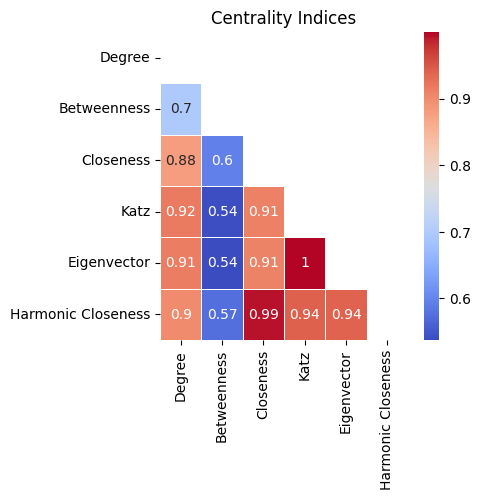

In [75]:
centralities_df = pd.DataFrame(centralities)
corr_matrix = centralities_df.corr()
plt.figure(figsize=(4, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask = np.triu(corr_matrix))
plt.title('Centrality Indices')
plt.show()

In [37]:
def get_top(centrality, n = 10):
    sorted_centrality = list((({k: v for k, v in sorted(centrality.items(), key = lambda item: item[1], reverse = True)}).items()))
    return sorted_centrality[:n]
    

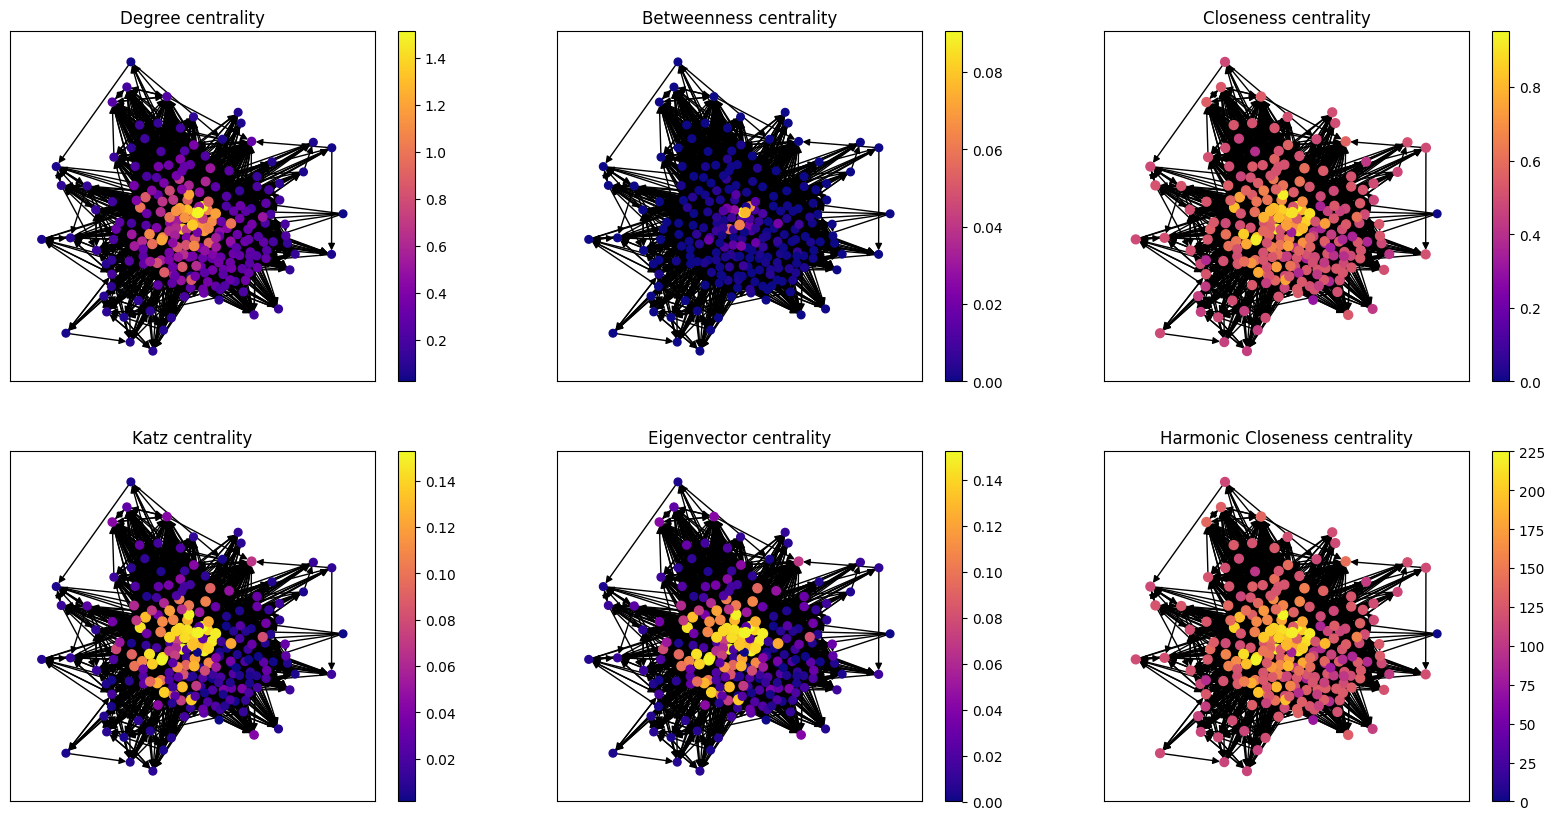

In [95]:
_, subp = plt.subplots(2, 3, figsize=(20, 10))
for idx, (k, v) in enumerate(centralities.items()):
    i = idx % 3
    j = math.floor(idx / 3)
    vmin = min(v.values())
    vmax = max(v.values())
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    colors = [plt.cm.plasma(norm(v[x])) for x in g.nodes]
    sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, orientation='vertical', ax = subp[j][i])
    nx.draw_networkx(g, pos=nx.spring_layout(g, seed = 8),  
                     ax = subp[j][i], node_size = np.interp(list(v.values()), (vmin, vmax), [30,50]),
                     with_labels=False, node_color = colors)
    subp[j][i].set(title = f"{k} centrality")
plt.show()